In [20]:
import numpy as np
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Point
import random
from shapely import affinity
import matplotlib.pyplot as plt
%matplotlib notebook

In [21]:
class Room():        
    def __init__(self, shape):
        self.shape = shape
        self.polygon = Polygon(np.array(shape, dtype=np.float64))

In [22]:
class FurnitureItem(): 
    def __init__(self, unitcost, shape):
        self.shape = shape
        self.unit_cost = unitcost
        self.polygon = Polygon(np.array(shape, dtype=np.float64))
        self.total_cost = np.float64((np.float64(self.unit_cost) * self.polygon.area))

In [23]:
class Problem():
    def __init__(self, room, furniture):
        self.room = room
        self.furniture = furniture

In [24]:
problems = []
with open('problems.rfp') as f:
    for line in f:
        furnitureList = []
        problem = line.replace(" ","").split("#")

        room_shape = problem[0].split(":")[1]
        furniture = problem[1].split(";")

        room = Room([tuple(np.float64(i) for i in el.strip('()').split(',')) for el in room_shape.split('),(')])

        for furnitureItem in furniture:
            parse_furniture = furnitureItem.strip().split(":")
            unit_cost = parse_furniture[0]
            shape = [tuple(np.float64(i) for i in el.strip('()').split(',')) for el in parse_furniture[1].split('),(')]
            furnitureItem = FurnitureItem(unit_cost, shape)
            furnitureList.append(furnitureItem)
        problems.append(Problem(room,furnitureList))

In [25]:
def plot(poly):
    x,y = poly.exterior.xy
    plt.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    plt.show()

In [26]:
len(problems[0].furniture)

94

In [191]:
def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)
    return points

In [ ]:
solution = []
room_2 = problems[28].room.polygon
shapes = copy.copy(problems[28].furniture)

while(room_2.area>56000):
    for j in shapes:
        points = random_points_within(room_2,1)[0]
        polygon = affinity.translate(j.polygon, points.x, points.y)
        polygon = affinity.rotate(polygon, random.uniform(0,90),origin="centroid")
        if room_2.contains(polygon):
            room_2 = room_2.difference(polygon)
            x,y = polygon.exterior.xy
            solution.append(list(zip(*(x,y))))
            shapes.remove(j)
            print(len(shapes))
room_2.area

319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209


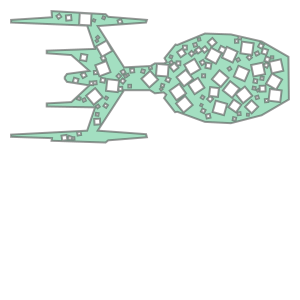

In [187]:
room_2

In [189]:
output = ""
for x in solution:
    output = output + str(x[:-1]).replace('[','').replace(']','') + "; "
print(output)

(340.9106023168728, 72.43800292630311), (342.6307594586418, 76.04924362828092), (339.019518756664, 77.76940077004991), (337.299361614895, 74.1581600680721); (171.22777599325678, 141.17505070636957), (174.79168082039678, 142.99125069070175), (172.9754808360646, 146.5551555178418), (169.4115760089246, 144.73895553350962); (447.64304490705734, 51.12193931235896), (447.8825680244343, 55.23808176327606), (443.7664255735172, 55.47760488065302), (443.5269024561402, 51.36146242973592); (97.00890279225698, 265.0816941118003), (98.47901944514194, 268.933804835405), (94.62690872153723, 270.40392148828994), (93.15679206865227, 266.55181076468523); (503.3797966423555, 181.0521653272708), (503.40434868251833, 186.05210504663984), (498.4044089631493, 186.0766570868027), (498.3798569229865, 181.07671736743367); (332.875450239061, 221.53224156838857), (337.73711889988306, 222.7002218046858), (336.5691386635858, 227.56189046550784), (331.7074700027638, 226.3939102292106); (124.45821847765066, 87.6559194

In [ ]:
58507.72798268754